In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt



### DATA LOADING:

Set up data model:
(Might need to recreate some of the dataframes from 1.02)

In [28]:
df = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/interim/filtered_dataset.csv")
df_ord = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/external/ORD_Weather.csv")
df_mdw = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/external/Midway_Weather.csv")

# create a df to aggreagate the number of crashes per day
df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")
print(df_crashes_per_day.head())



#print(df.head())
#print(df_ord.head())
#df_ord.info()


#df_ord.shape()
#df_ord.info()     # Overview of column types and missing values
#df_ord.describe()   # Summary statistics for numeric columns
#df_ord.isnull().sum()

   CRASH_DATE  Total_Crashes
0  2018-01-01            337
1  2018-01-02            452
2  2018-01-03            383
3  2018-01-04            360
4  2018-01-05            373


In [29]:
#print(df_ord.head())
#print(df_ord.info())
print(df_mdw.info())
print(df_ord.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          2557 non-null   object 
 1   NAME             2557 non-null   object 
 2   LATITUDE         2557 non-null   float64
 3   LONGITUDE        2557 non-null   float64
 4   ELEVATION        2557 non-null   float64
 5   DATE             2557 non-null   object 
 6   AWND             2556 non-null   float64
 7   AWND_ATTRIBUTES  2556 non-null   object 
 8   PGTM             826 non-null    float64
 9   PGTM_ATTRIBUTES  826 non-null    object 
 10  PRCP             2553 non-null   float64
 11  PRCP_ATTRIBUTES  2553 non-null   object 
 12  SNOW             207 non-null    float64
 13  SNOW_ATTRIBUTES  207 non-null    object 
 14  SNWD             594 non-null    float64
 15  SNWD_ATTRIBUTES  594 non-null    object 
 16  TAVG             0 non-null      float64
 17  TAVG_ATTRIBUTE

### DATA CLEANING

Need to rename the columns in the ORD weather dataset for easy understanding.

We need to label the fields from each dataset so that when we merge them, we know where each column came from.

In [30]:
# Example for Midway (already done)
rename_ord_dict = {
    "DATE": "CRASH_DATE",
    "AWND": "Avg_Wind_Speed_ORD",
    "PRCP": "Precipitation_ORD",
    "SNOW": "Snowfall_ORD",
    "SNWD": "Snow_Depth_ORD",
    "TAVG": "Avg_Temperature_ORD",
    "TMAX": "Max_Temperature_ORD",
    "TMIN": "Min_Temperature_ORD",
    "WT01": "Fog_ORD",
    "WT02": "Heavy_Fog_ORD",
    "WT03": "Thunder_ORD",
    "WT04": "Ice_Pellets_ORD",
    "WT05": "Hail_ORD",
    "WT06": "Glaze_Ice_ORD",
    "WT08": "Smoke_ORD",
    "WT09": "Blowing_Snow_ORD",
}
rename_mdw_dict = {
    "DATE": "CRASH_DATE",
    "AWND": "Avg_Wind_Speed_MDW",
    "PRCP": "Precipitation_MDW",
    "SNOW": "Snowfall_MDW",
    "SNWD": "Snow_Depth_MDW",
    "TAVG": "Avg_Temperature_MDW",
    "TMAX": "Max_Temperature_MDW",
    "TMIN": "Min_Temperature_MDW",
    "WT01": "Fog_MDW",
    "WT02": "Heavy_Fog_MDW",
    "WT03": "Thunder_MDW",
    "WT04": "Ice_Pellets_MDW",
    "WT05": "Hail_MDW",
    "WT06": "Glaze_Ice_MDW",
    "WT08": "Smoke_MDW",
    "WT09": "Blowing_Snow_MDW",
}

# Apply renaming to the dataframe
df_ord = df_ord.rename(columns=rename_ord_dict)
df_mdw = df_mdw.rename(columns=rename_mdw_dict)


In [31]:
# view all columns in both df
#print(df_ord.head())
#print(df_mdw.head())
print(df_ord.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STATION              2557 non-null   object 
 1   NAME                 2557 non-null   object 
 2   LATITUDE             2557 non-null   float64
 3   LONGITUDE            2557 non-null   float64
 4   ELEVATION            2557 non-null   float64
 5   CRASH_DATE           2557 non-null   object 
 6   Avg_Wind_Speed_ORD   2556 non-null   float64
 7   AWND_ATTRIBUTES      2556 non-null   object 
 8   PGTM                 35 non-null     float64
 9   PGTM_ATTRIBUTES      35 non-null     object 
 10  Precipitation_ORD    2557 non-null   float64
 11  PRCP_ATTRIBUTES      2557 non-null   object 
 12  Snowfall_ORD         2557 non-null   float64
 13  SNOW_ATTRIBUTES      2557 non-null   object 
 14  Snow_Depth_ORD       2556 non-null   float64
 15  SNWD_ATTRIBUTES      2556 non-null   o

Now let's merge both of the weather dataframes:

1. Get rid of the unnecessary data fields
2. Fill in any zeros/gaps
3. Merge

In [32]:
# 1. Get rid of the unnecessary columns
ord_keep_cols = [
    "CRASH_DATE",
    "Avg_Wind_Speed_ORD",
    "Precipitation_ORD",
    "Snowfall_ORD",
    "Snow_Depth_ORD",
    "Avg_Temperature_ORD",
    "Max_Temperature_ORD",
    "Min_Temperature_ORD",
    "Fog_ORD",
    "Heavy_Fog_ORD",
    "Thunder_ORD",
    "Ice_Pellets_ORD",
    "Hail_ORD",
    "Glaze_Ice_ORD",
    "Smoke_ORD",
    "Blowing_Snow_ORD"
]
mdw_keep_cols = [
    "CRASH_DATE",
    "Avg_Wind_Speed_MDW",
    "Precipitation_MDW",
    "Snowfall_MDW",
    "Snow_Depth_MDW",
    "Avg_Temperature_MDW",
    "Max_Temperature_MDW",
    "Min_Temperature_MDW",
    "Fog_MDW",
    "Heavy_Fog_MDW",
    "Thunder_MDW",
    "Ice_Pellets_MDW",
    "Hail_MDW",
    "Glaze_Ice_MDW",
    "Smoke_MDW",
    "Blowing_Snow_MDW"
]

# Filter only the above columns (so there are no unnecessary columns)
df_ord_filtered = df_ord[ord_keep_cols]
df_mdw_filtered = df_mdw[mdw_keep_cols]

In [33]:
# 2. Fill in any missing values

# check to see if there are any missing values
print(df_ord_filtered.isnull().sum())
print(df_mdw_filtered.isnull().sum())


# check unqiue values for each column to see what we need to fill in
weather_event_columns_ord = ["Fog_ORD", "Heavy_Fog_ORD", "Thunder_ORD", "Ice_Pellets_ORD", "Hail_ORD", "Glaze_Ice_ORD", "Smoke_ORD", "Blowing_Snow_ORD"]
weather_event_columns_mdw = ["Fog_MDW", "Heavy_Fog_MDW", "Thunder_MDW", "Ice_Pellets_MDW", "Hail_MDW", "Glaze_Ice_MDW", "Smoke_MDW", "Blowing_Snow_MDW"]

for col in weather_event_columns_ord:
    print(f"{col}: {df_ord_filtered[col].unique()}")
    # results: these are all binary flags, either 1 or NaN



CRASH_DATE                0
Avg_Wind_Speed_ORD        1
Precipitation_ORD         0
Snowfall_ORD              0
Snow_Depth_ORD            1
Avg_Temperature_ORD       0
Max_Temperature_ORD       0
Min_Temperature_ORD       0
Fog_ORD                1550
Heavy_Fog_ORD          2492
Thunder_ORD            2235
Ice_Pellets_ORD        2522
Hail_ORD               2535
Glaze_Ice_ORD          2516
Smoke_ORD              2120
Blowing_Snow_ORD       2529
dtype: int64
CRASH_DATE                0
Avg_Wind_Speed_MDW        1
Precipitation_MDW         4
Snowfall_MDW           2350
Snow_Depth_MDW         1963
Avg_Temperature_MDW    2557
Max_Temperature_MDW       0
Min_Temperature_MDW       0
Fog_MDW                1864
Heavy_Fog_MDW          2531
Thunder_MDW            2318
Ice_Pellets_MDW        2535
Hail_MDW               2552
Glaze_Ice_MDW          2542
Smoke_MDW              2343
Blowing_Snow_MDW       2545
dtype: int64
Fog_ORD: [nan  1.]
Heavy_Fog_ORD: [nan  1.]
Thunder_ORD: [nan  1.]
Ice_Pellets

In [34]:
# Handle missing values

## fix df_ord_filtered
df_ord_filtered["Snow_Depth_ORD"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
df_ord_filtered["Avg_Wind_Speed_ORD"].fillna(0, inplace=True) # One missing windspeed value... assume 0 wind

# fix binary weather event columns
for col in weather_event_columns_ord:
    df_ord_filtered[col].fillna(0, inplace=True)

# fix df_mdw_filtered
df_mdw_filtered["Avg_Wind_Speed_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 wind
df_mdw_filtered["Precipitation_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 precipitation
df_mdw_filtered["Snowfall_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
df_mdw_filtered["Snow_Depth_MDW"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall

# calculate average temperature values (all values are missing currently)
df_mdw_filtered["Avg_Temperature_MDW"] = (df_ord_filtered["Max_Temperature_ORD"] + df_ord_filtered["Min_Temperature_ORD"]) / 2

# fix binary weather event columns
for col in weather_event_columns_mdw:
    df_mdw_filtered[col].fillna(0, inplace=True)



C:\Users\chris\AppData\Local\Temp\ipykernel_37144\451734638.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ord_filtered["Snow_Depth_ORD"].fillna(0, inplace=True) # One missing snow value... assume 0 snowfall
C:\Users\chris\AppData\Local\Temp\ipykernel_37144\451734638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ord_filtered["

In [35]:
print(df_ord_filtered.isnull().sum()) #check that the important variables are not missing
print(df_mdw_filtered.isnull().sum()) #check that the important variables are not missing

CRASH_DATE             0
Avg_Wind_Speed_ORD     0
Precipitation_ORD      0
Snowfall_ORD           0
Snow_Depth_ORD         0
Avg_Temperature_ORD    0
Max_Temperature_ORD    0
Min_Temperature_ORD    0
Fog_ORD                0
Heavy_Fog_ORD          0
Thunder_ORD            0
Ice_Pellets_ORD        0
Hail_ORD               0
Glaze_Ice_ORD          0
Smoke_ORD              0
Blowing_Snow_ORD       0
dtype: int64
CRASH_DATE             0
Avg_Wind_Speed_MDW     0
Precipitation_MDW      0
Snowfall_MDW           0
Snow_Depth_MDW         0
Avg_Temperature_MDW    0
Max_Temperature_MDW    0
Min_Temperature_MDW    0
Fog_MDW                0
Heavy_Fog_MDW          0
Thunder_MDW            0
Ice_Pellets_MDW        0
Hail_MDW               0
Glaze_Ice_MDW          0
Smoke_MDW              0
Blowing_Snow_MDW       0
dtype: int64


In [36]:
# 2. Merge the two dataframes on the CRASH_DATE column
df_weather_merged = pd.merge(df_ord_filtered, df_mdw_filtered, on="CRASH_DATE", how="inner")

Merge the two datasets (df_crashes_per_day and df_weather_merged) based on date. 

Why are we doing this on crashes per day and not indidivual crashes?
- weather applies to the entire day, not just each individ crash
- time series works ebst with aggregated data
- simplify the dataset

In [37]:
# Ensure CRASH_DATE is in datetime format (if not already)
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

# Aggregate total crashes per day
df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")

# Display the first few rows
print(df_crashes_per_day.head())

  CRASH_DATE  Total_Crashes
0 2018-01-01            337
1 2018-01-02            452
2 2018-01-03            383
3 2018-01-04            360
4 2018-01-05            373


In [41]:
df_weather_merged["CRASH_DATE"] = pd.to_datetime(df_weather_merged["CRASH_DATE"])

# Merge crash data with weather data
df_merged = pd.merge(df_crashes_per_day, df_weather_merged, on="CRASH_DATE", how="left")

# Verify the merged dataset
df_merged.head()

,CRASH_DATE,Total_Crashes,Avg_Wind_Speed_ORD,Precipitation_ORD,Snowfall_ORD,Snow_Depth_ORD,Avg_Temperature_ORD,Max_Temperature_ORD,Min_Temperature_ORD,Fog_ORD,...,Max_Temperature_MDW,Min_Temperature_MDW,Fog_MDW,Heavy_Fog_MDW,Thunder_MDW,Ice_Pellets_MDW,Hail_MDW,Glaze_Ice_MDW,Smoke_MDW,Blowing_Snow_MDW
0,2018-01-01,337,10.74,0.0,0.0,1.2,-2,1,-9,0.0,...,3,-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,452,11.18,0.0,0.0,1.2,-2,8,-9,0.0,...,7,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03,383,12.30,0.0,0.1,1.2,11,17,6,1.0,...,18,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04,360,12.30,0.0,0.0,1.2,7,12,0,0.0,...,13,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05,373,10.74,0.0,0.0,1.2,5,11,-1,0.0,...,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_merged.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CRASH_DATE           2557 non-null   datetime64[ns]
 1   Total_Crashes        2557 non-null   int64         
 2   Avg_Wind_Speed_ORD   2557 non-null   float64       
 3   Precipitation_ORD    2557 non-null   float64       
 4   Snowfall_ORD         2557 non-null   float64       
 5   Snow_Depth_ORD       2557 non-null   float64       
 6   Avg_Temperature_ORD  2557 non-null   int64         
 7   Max_Temperature_ORD  2557 non-null   int64         
 8   Min_Temperature_ORD  2557 non-null   int64         
 9   Fog_ORD              2557 non-null   float64       
 10  Heavy_Fog_ORD        2557 non-null   float64       
 11  Thunder_ORD          2557 non-null   float64       
 12  Ice_Pellets_ORD      2557 non-null   float64       
 13  Hail_ORD             2557 non-nul

In [43]:
# check to see if there are any missing values
print(df_merged.isnull().sum())


CRASH_DATE             0
Total_Crashes          0
Avg_Wind_Speed_ORD     0
Precipitation_ORD      0
Snowfall_ORD           0
Snow_Depth_ORD         0
Avg_Temperature_ORD    0
Max_Temperature_ORD    0
Min_Temperature_ORD    0
Fog_ORD                0
Heavy_Fog_ORD          0
Thunder_ORD            0
Ice_Pellets_ORD        0
Hail_ORD               0
Glaze_Ice_ORD          0
Smoke_ORD              0
Blowing_Snow_ORD       0
Avg_Wind_Speed_MDW     0
Precipitation_MDW      0
Snowfall_MDW           0
Snow_Depth_MDW         0
Avg_Temperature_MDW    0
Max_Temperature_MDW    0
Min_Temperature_MDW    0
Fog_MDW                0
Heavy_Fog_MDW          0
Thunder_MDW            0
Ice_Pellets_MDW        0
Hail_MDW               0
Glaze_Ice_MDW          0
Smoke_MDW              0
Blowing_Snow_MDW       0
dtype: int64


### PROPHET SEASONAL FORECASTING

Set up prophet to do SARIMAX:

In [95]:
from prophet import Prophet
import matplotlib.pyplot as plt

# STEP 1: Prepare the dataframe
# Prophet requires columns named 'ds' (date) and 'y' (target)
df_merged["CRASH_DATE"] = pd.to_datetime(df_merged["CRASH_DATE"])
df_prophet = df_merged.reset_index()[["Total_Crashes", "Precipitation_ORD"]].copy()
df_prophet["ds"] = df_merged["CRASH_DATE"] # set CRASH_DATE as 'ds'
df_prophet["y"] = df_prophet["Total_Crashes"]

# STEP 2: Initialize the model and add weather regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.add_regressor("Precipitation_ORD")
#model.add_regressor("Precipitation_MDW") # these are highly correlated, so we only need one

In [97]:
print(df_prophet.head(50))

    Total_Crashes  Precipitation_ORD         ds    y
0             337               0.00 2018-01-01  337
1             452               0.00 2018-01-02  452
2             383               0.00 2018-01-03  383
3             360               0.00 2018-01-04  360
4             373               0.00 2018-01-05  373
5             330               0.00 2018-01-06  330
6             210               0.03 2018-01-07  210
7             279               0.00 2018-01-08  279
8             276               0.00 2018-01-09  276
9             311               0.01 2018-01-10  311
10            342               0.36 2018-01-11  342
11            353               0.00 2018-01-12  353
12            288               0.00 2018-01-13  288
13            226               0.08 2018-01-14  226
14            263               0.14 2018-01-15  263
15            335               0.01 2018-01-16  335
16            397               0.00 2018-01-17  397
17            372               0.00 2018-01-1

In [98]:
# STEP 2: Fit the model
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
model.fit(df_prophet)


23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# STEP 3: Create future dataframe
future = model.make_future_dataframe(periods=365)  # forecast 1 year 

In [ ]:
# STEP 4: Add weather regressors to the future dataframe
# NOTE: You must supply values for the regressors even in the future period

# Merge past weather data
future = pd.merge(future, df_prophet[["ds", "Precipitation_ORD"]], on="ds", how="left")

# You can fill future values manually or interpolate (for now, we'll forward fill)
future["Precipitation_ORD"] = future["Precipitation_ORD"].fillna(method="ffill")
#future["Precipitation_MDW"] = future["Precipitation_MDW"].fillna(method="ffill")


C:\Users\chris\AppData\Local\Temp\ipykernel_37144\3378304599.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["Precipitation_ORD"] = future["Precipitation_ORD"].fillna(method="ffill")


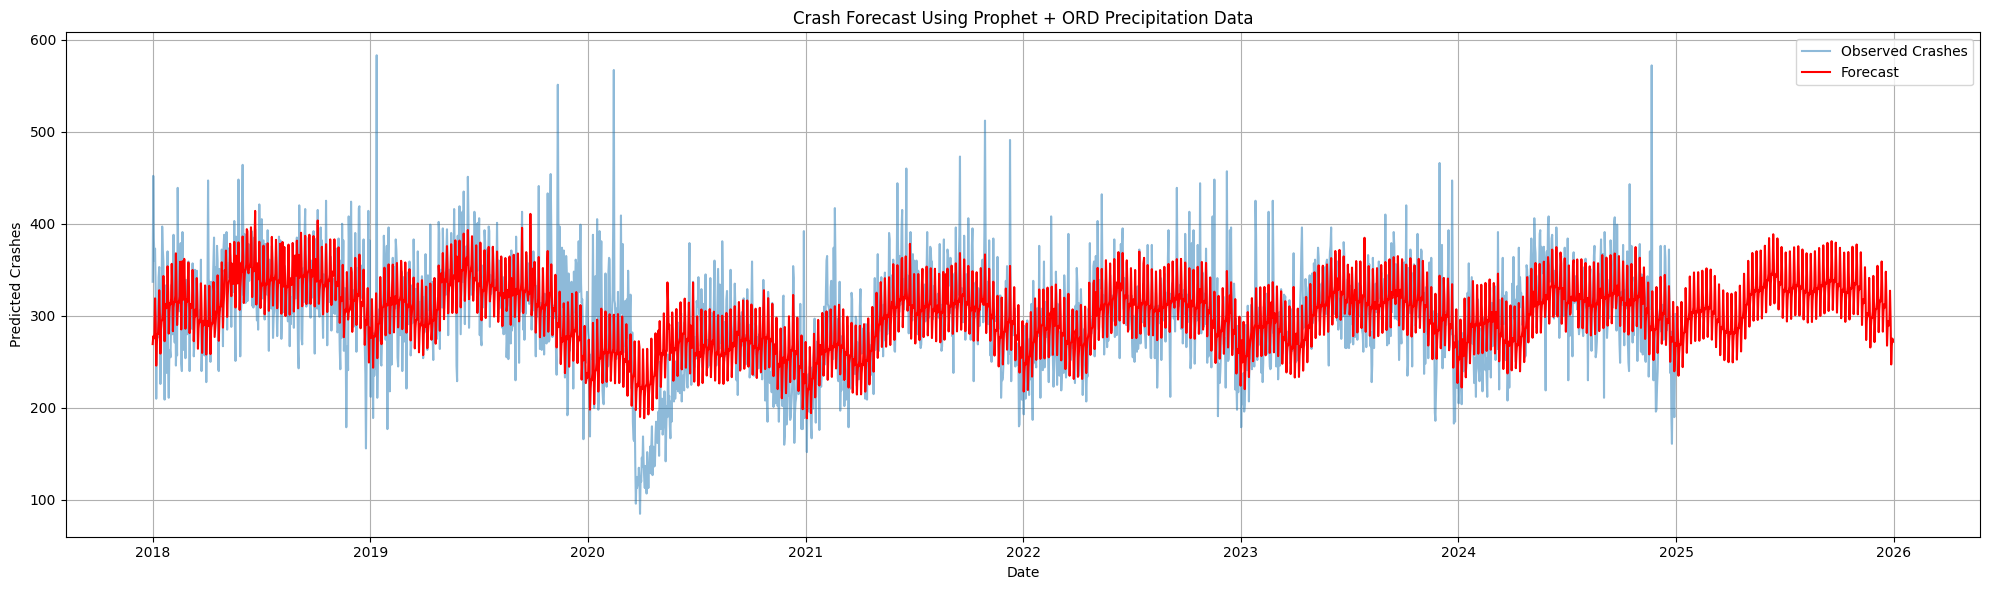

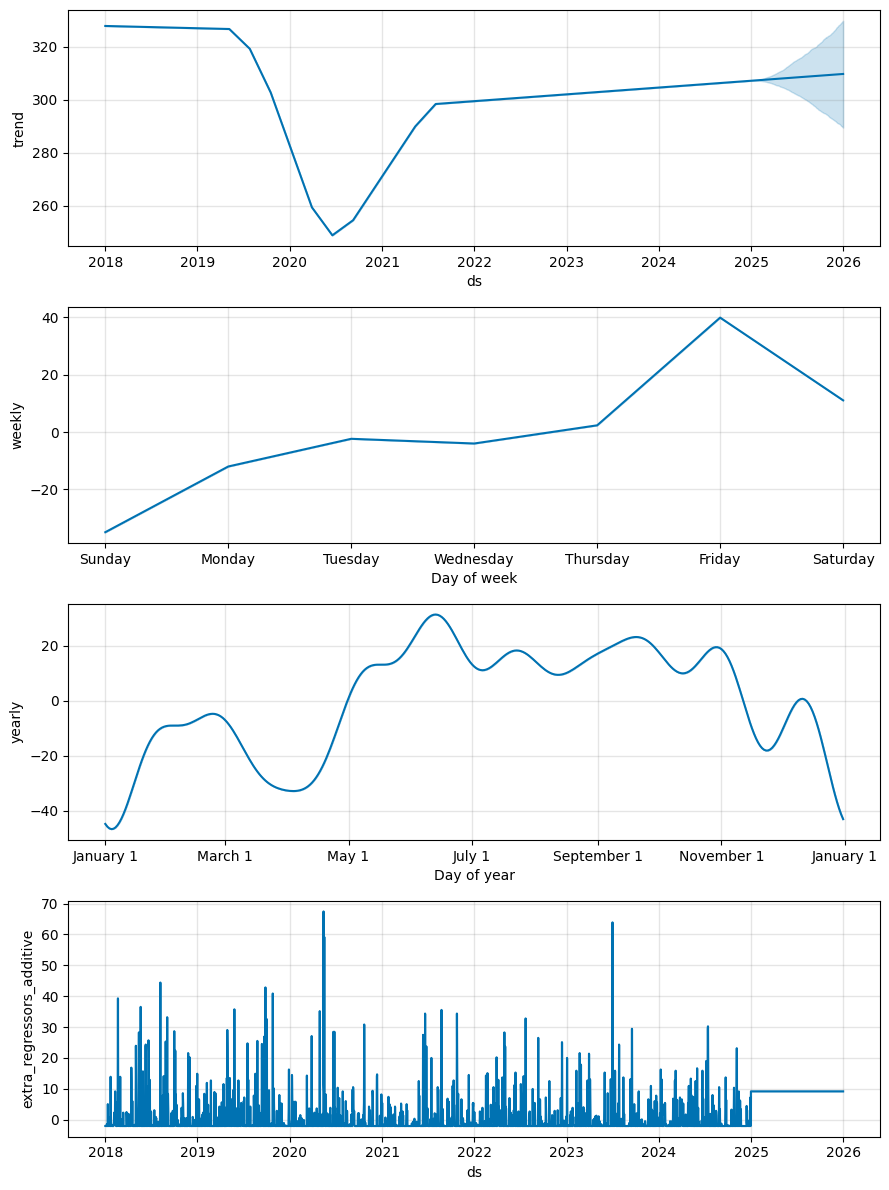

In [ ]:
# STEP 5: Forecast
forecast = model.predict(future)

# STEP 6: Plot forecast
plt.figure(figsize=(20, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed Crashes", alpha=0.5)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.title("Crash Forecast Using Prophet + ORD Precipitation Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# STEP 7:Forecast Components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [ ]:
# STEP 8: Evaluate the model
# Calculate RMSE
y_true = df_prophet["y"]
y_pred = forecast["yhat"][:len(y_true)]
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")


RMSE: 41.96605599225603


Let's do the same steps, but this time with MDW precipitation data

In [99]:
# STEP 1: Prepare the dataframe
# Prophet requires columns named 'ds' (date) and 'y' (target)
df_merged["CRASH_DATE"] = pd.to_datetime(df_merged["CRASH_DATE"])
df_prophet = df_merged.reset_index()[["Total_Crashes", "Precipitation_MDW"]].copy()
df_prophet["ds"] = df_merged["CRASH_DATE"] # set CRASH_DATE as 'ds'
df_prophet["y"] = df_prophet["Total_Crashes"]

# STEP 2: Initialize the model and add weather regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.add_regressor("Precipitation_MDW") 

In [100]:
# STEP 2: Fit the model
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
model.fit(df_prophet)

23:30:29 - cmdstanpy - INFO - Chain [1] start processing
23:30:30 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
# STEP 3: Create future dataframe
future = model.make_future_dataframe(periods=365)  # forecast 1 year 

In [102]:
# STEP 4: Add weather regressors to the future dataframe
# NOTE: You must supply values for the regressors even in the future period

# Merge past weather data
future = pd.merge(future, df_prophet[["ds", "Precipitation_MDW"]], on="ds", how="left")

# You can fill future values manually or interpolate (for now, we'll forward fill)
future["Precipitation_MDW"] = future["Precipitation_MDW"].fillna(method="ffill")

C:\Users\chris\AppData\Local\Temp\ipykernel_37144\2675563593.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["Precipitation_MDW"] = future["Precipitation_MDW"].fillna(method="ffill")


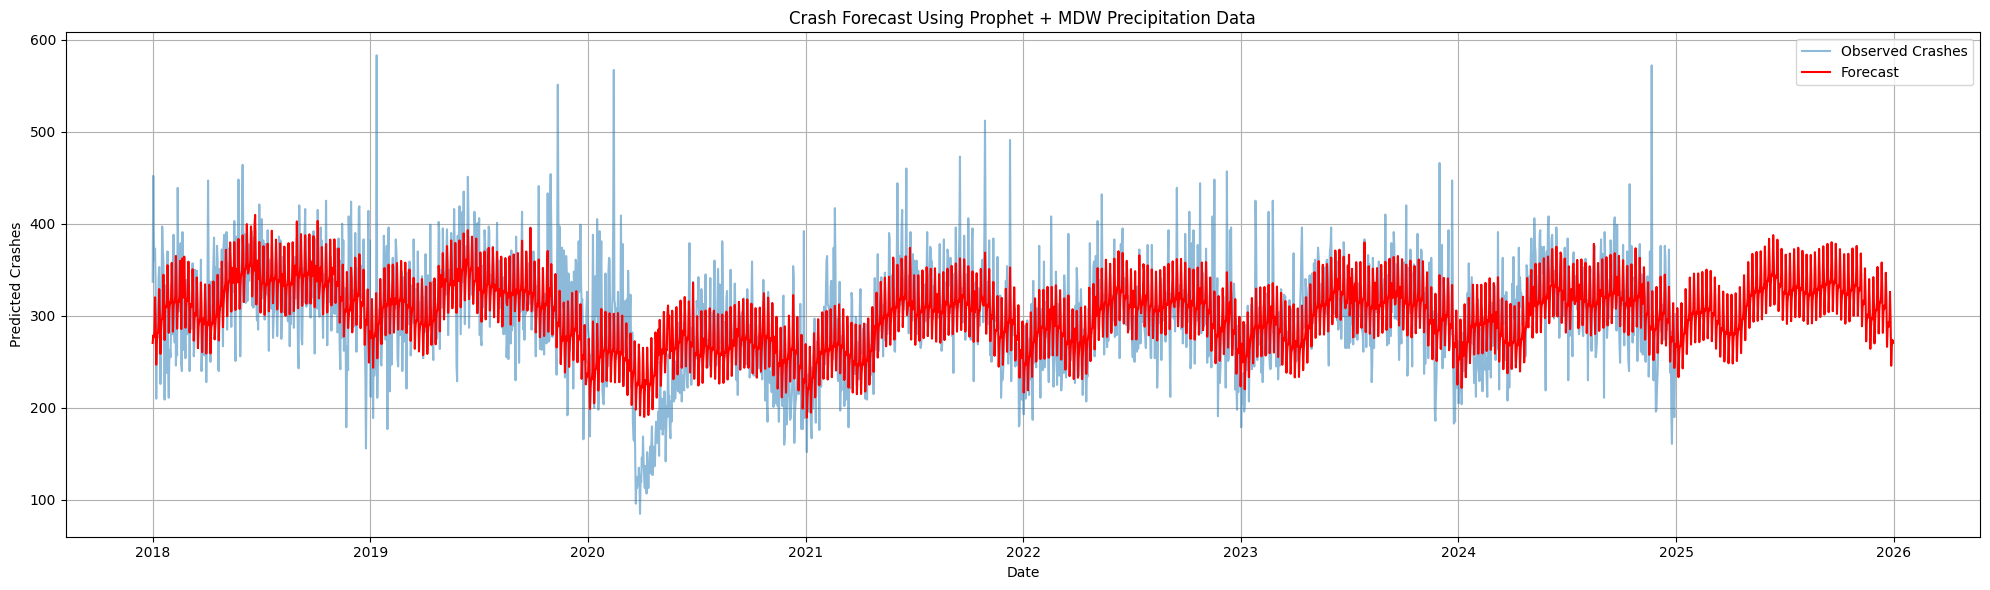

In [103]:
# STEP 5: Forecast
forecast = model.predict(future)

# STEP 6: Plot forecast
plt.figure(figsize=(20, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed Crashes", alpha=0.5)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Predicted Crashes")
plt.title("Crash Forecast Using Prophet + MDW Precipitation Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


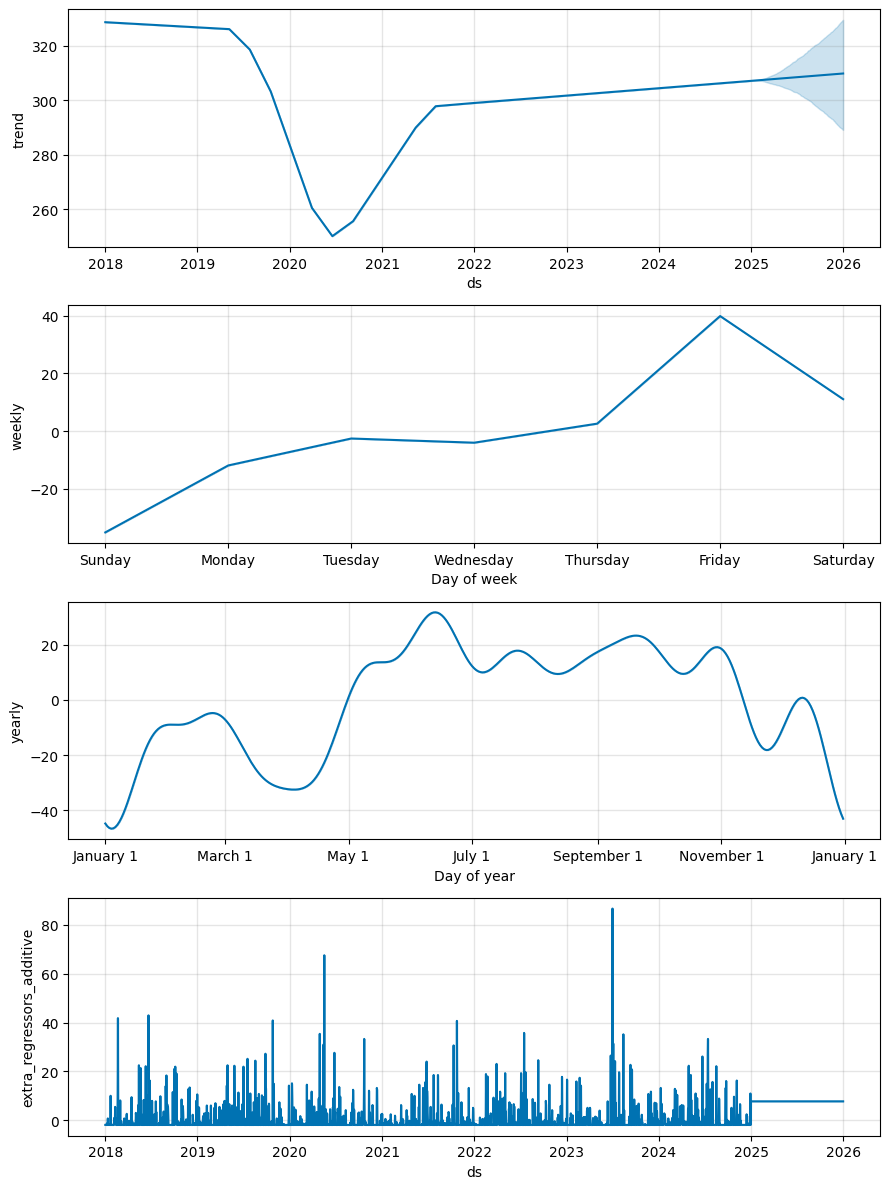

In [104]:
# STEP 7:Forecast Components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [105]:
# STEP 8: Evaluate the model
# Calculate RMSE
y_true = df_prophet["y"]
y_pred = forecast["yhat"][:len(y_true)]
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")


RMSE: 42.04963700253742


Comparing the two RMSE values:
ORD: 41.96606
MDW: 42.04964

ORD is barely smaller. The precipitation values are likely extremely similar between the two airports. 

-----------------------
Let's compare to a SARIMAX model without using Prophet. 


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Filter and prepare data ---
df_train_SARIMAX_22_24 = df_merged[(df_merged['CRASH_DATE'] >= '2022-01-01') & (df_merged['CRASH_DATE'] <= '2024-12-31')].copy()
df_train_SARIMAX_22_24['CRASH_DATE'] = pd.to_datetime(df_train_SARIMAX_22_24['CRASH_DATE'])
df_train_SARIMAX_22_24.set_index('CRASH_DATE', inplace=True)

endog = df_train_SARIMAX_22_24['Total_Crashes']
exog = df_train_SARIMAX_22_24[['Precipitation_ORD']]

In [114]:
# --- Fit SARIMAX Model ---
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
results = model.fit(disp=False)

c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Forecast
forecast_steps = 365
future_dates = pd.date_range(start=df_train_SARIMAX_22_24.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_exog = pd.DataFrame({'Precipitation_ORD': [exog['Precipitation_ORD'].mean()] * forecast_steps}, index=future_dates)

forecast = results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [116]:
# --- Ensure clean types ---
forecast_ci = forecast_ci.astype(float)
forecast_ci.index = pd.to_datetime(forecast_ci.index)
forecast_mean = forecast_mean.astype(float)


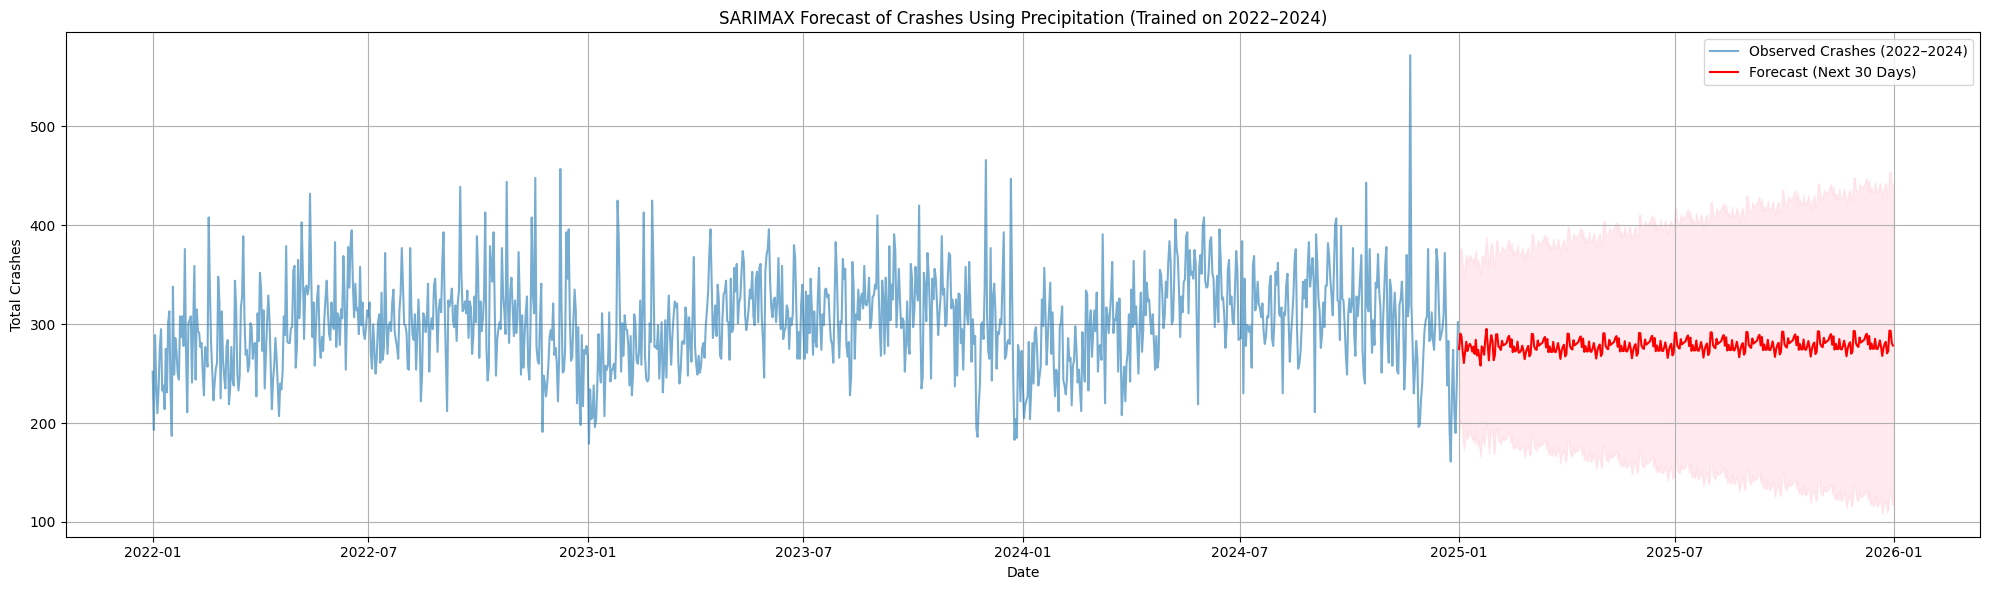

In [117]:
# --- Plot ---
plt.figure(figsize=(20, 6))
plt.plot(endog.index, endog, label='Observed Crashes (2022–2024)', alpha=0.6)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (Next 30 Days)', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total Crashes')
plt.title('SARIMAX Forecast of Crashes Using Precipitation (Trained on 2022–2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The red forecast line in the above SARIMAX model looks way too flat and lacks the kind of seasonal variation we’d expect based on previous trends. Why is that happening? 

-  I'm passing a constant average precipitation value (exog.mean()) for every day in the future:
    - future_exog = pd.DataFrame({'Precipitation_ORD': [exog['Precipitation_ORD'].mean()] * forecast_steps}, index=future_dates)

By doing this, I'm telling the model "Assume weather will be the same every day/month in the future."

So even though the SARIMAX model was trained with seasonality, it no longer has the seasonal fluctuation from the weather variable to drive those effects in the forecast.

How can we fix this?

- Use Actual or Simulated Future Weather Data (simulate by repeating last year's pattern)
- Model seasonality in the Endogenous variable instead (use SARIMA instead of SARIMAX)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define endog (target variable) and exog (external variables)
endog = df_train_SARIMAX_22_24["Total_Crashes"]
exog = df_train_SARIMAX_22_24[["Precipitation_ORD"]]

# Option 1: Use mean value of future exog
forecast_steps = 365
future_dates = pd.date_range(start=df_train_SARIMAX_22_24.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
future_exog_mean = pd.DataFrame({"Precipitation_ORD": [exog["Precipitation_ORD"].mean()] * forecast_steps}, index=future_dates)

# Option 2: Repeat the most recent year of exog data
recent_year_start = df_train_SARIMAX_22_24.index.max() - pd.DateOffset(days=364)
recent_exog = exog[recent_year_start:].copy()
recent_exog.index = future_dates  # align index to future

# Fit SARIMAX model
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
results = model.fit(disp=False)

# Forecast using both options
forecast_mean_1 = results.get_forecast(steps=forecast_steps, exog=future_exog_mean).predicted_mean
forecast_mean_2 = results.get_forecast(steps=forecast_steps, exog=recent_exog).predicted_mean

# Combine into a DataFrame for plotting
forecast_comparison = pd.DataFrame({
    "Option_1_MeanExog": forecast_mean_1,
    "Option_2_RepeatedExog": forecast_mean_2
})



c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


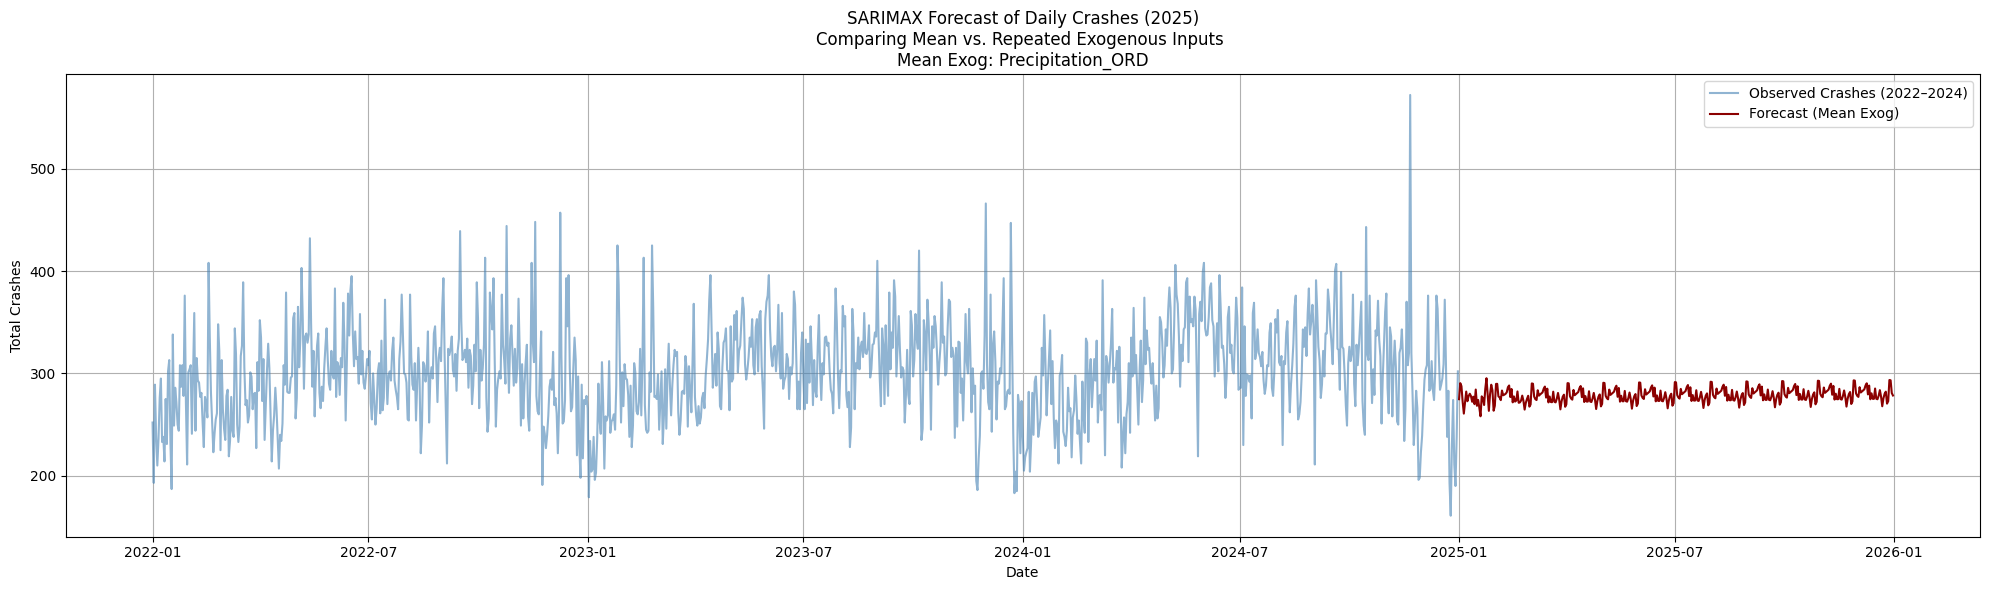

In [127]:
plt.figure(figsize=(20, 6))

# observed crash data
plt.plot(df_train_SARIMAX_22_24.index,
         df_train_SARIMAX_22_24["Total_Crashes"],
         label="Observed Crashes (2022–2024)", color="steelblue", alpha=0.6)

# Model 1 – Forecast using mean exog
plt.plot(forecast_mean_1.index,
         forecast_mean_1,
         label="Forecast (Mean Exog)", color="darkred")
# Formatting
plt.title("SARIMAX Forecast of Daily Crashes (2025)\nComparing Mean vs. Repeated Exogenous Inputs \nMean Exog: Precipitation_ORD")
plt.xlabel("Date")
plt.ylabel("Total Crashes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


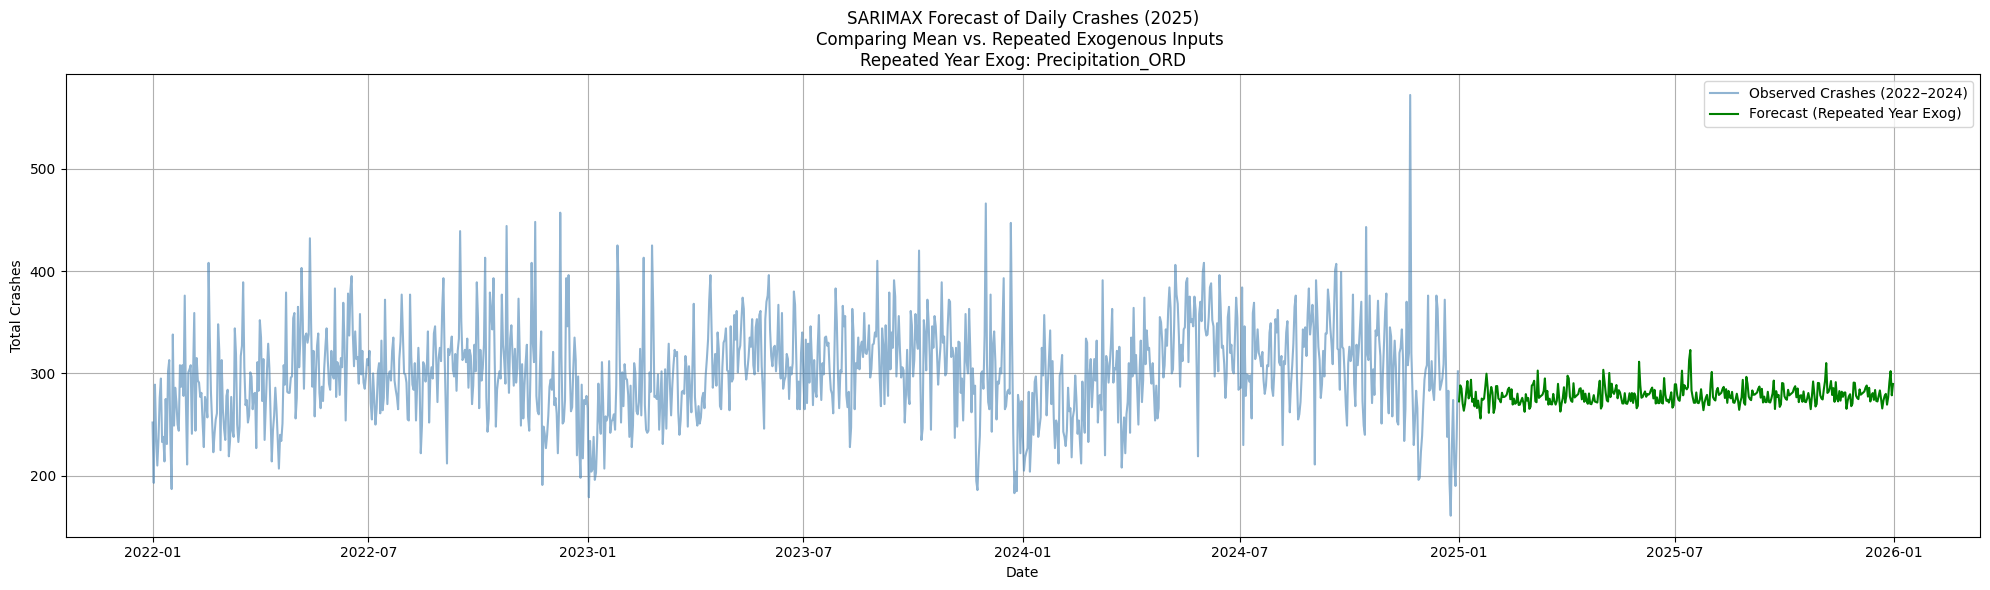

In [130]:
plt.figure(figsize=(20, 6))
# observed crash data
plt.plot(df_train_SARIMAX_22_24.index,
         df_train_SARIMAX_22_24["Total_Crashes"],
         label="Observed Crashes (2022–2024)", color="steelblue", alpha=0.6)

# # Model 2 – Forecast using repeated last year of exog
plt.plot(forecast_mean_2.index,
         forecast_mean_2,
         label="Forecast (Repeated Year Exog)", color="green")

# Formatting
plt.title("SARIMAX Forecast of Daily Crashes (2025)\nComparing Mean vs. Repeated Exogenous Inputs \nRepeated Year Exog: Precipitation_ORD")
plt.xlabel("Date")
plt.ylabel("Total Crashes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary of the two SARIMAX models:

Model 1: Using the mean Exogenous Value
For all future days, it uses the average precipitation value from the training period (2022–2024). It assumes the weather (precipitation) in the future will be typical or average. This leads to a FLAT forecast, since the weather input doesn't vary.

Model 2: Using the previous year of exogenous values
This model takes the actual precipitation values from the last year (2024) and repeats them into 2025. It assumes the future weather will follow a similar seasonal pattern as the most recent year. This produces a more realistic and seasonally driven forecast with day-to-day variation. 

------------------
## How well does SARIMAX model the actual data? Is this the best model to use?

Let's explore how well does the SARIMAX model fit the actual data. Does it have large residuals?

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Step 1: Prepare the data (2022–2024) ---
#df_full = df_full.asfreq("D")  # Ensure daily frequency

# --- Step 2: Define variables ---
endog = df_train_SARIMAX_22_24['Total_Crashes']
exog = df_train_SARIMAX_22_24[['Precipitation_ORD']]

# --- Step 3: Fit SARIMAX model ---
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)

# --- Step 4: Get fitted values and residuals ---
predicted = results.fittedvalues
residuals = endog - predicted


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


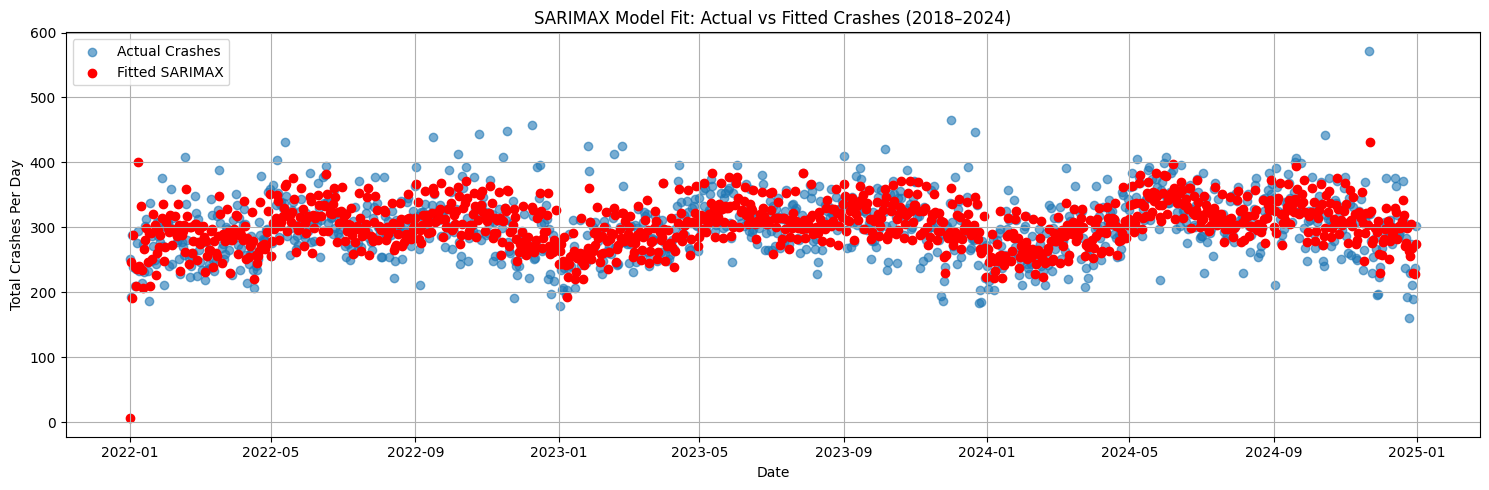

In [ ]:
# --- Plot observed vs. fitted values ---
plt.figure(figsize=(15, 5))
plt.scatter(endog.index, endog, label="Actual Crashes", alpha=0.6)
plt.scatter(predicted.index, predicted, label="Fitted SARIMAX", color="red")
plt.title("SARIMAX Model Fit: Actual vs Fitted Crashes (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Total Crashes Per Day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


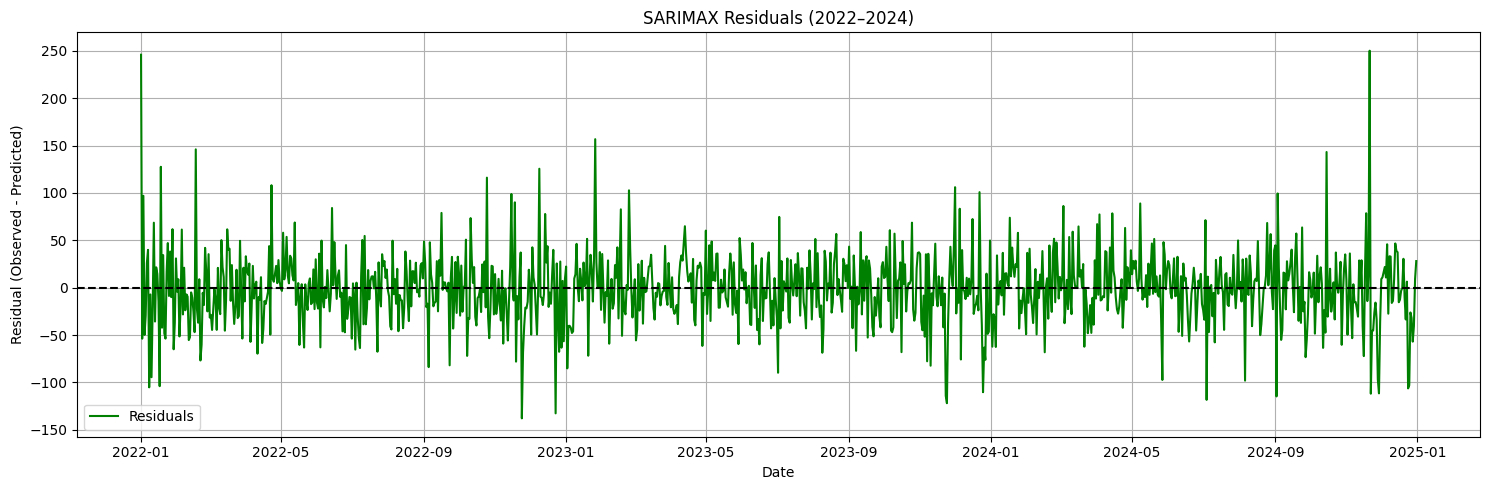

In [80]:
# --- Step 5: Plot residuals ---
plt.figure(figsize=(15, 5))
plt.plot(residuals, label='Residuals', color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title("SARIMAX Residuals (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Residual (Observed - Predicted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


These residuals actually seem fairly large. It looks like they average around 50. 

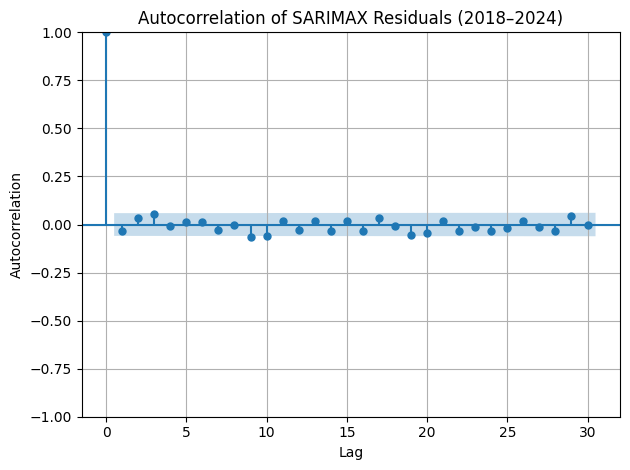

In [ ]:
# Plot autocorrelation of residuals
plot_acf(residuals.dropna(), lags=30)
plt.title("Autocorrelation of SARIMAX Residuals (2022–2024)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

There doesn't seem to be any large values, patterns or spikes. This means the residuals are random and there isn't any autocorrelation at any lag.

In [133]:
# RMSE
rmse = np.sqrt(mean_squared_error(endog.dropna(), predicted.dropna()))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 38.47


-------------------
## Running SARIMAX on different variables and comparing RMSE
I want to see which variables will forecast the data best in terms of weather and also airport. 

Below, let's create a loop to do that

In [134]:
from sklearn.metrics import mean_squared_error

# Define target variable (endogenous)
endog = df_train_SARIMAX_22_24['Total_Crashes']

# create difference variables
df_train_SARIMAX_22_24['Precipitation_Diff'] = df_train_SARIMAX_22_24['Precipitation_ORD'] - df_train_SARIMAX_22_24['Precipitation_MDW']
df_train_SARIMAX_22_24['Avg_Temperature_Diff'] = df_train_SARIMAX_22_24['Avg_Temperature_ORD'] - df_train_SARIMAX_22_24['Avg_Temperature_MDW']
df_train_SARIMAX_22_24['Snowfall_Diff'] = df_train_SARIMAX_22_24['Snowfall_ORD'] - df_train_SARIMAX_22_24['Snowfall_MDW']

# STEP 3: Weather variables to compare
weather_vars = [
    ['Precipitation_ORD'],
    ['Precipitation_MDW'],
    ['Precipitation_Diff'],
    ['Avg_Temperature_ORD'],
    ['Avg_Temperature_MDW'],
    ['Avg_Temperature_Diff'],
    ['Snowfall_ORD'],
    ['Snowfall_MDW'],
    ['Snowfall_Diff']
]

# STEP 4: Loop through variables and evaluate SARIMAX model
results_list = []

for var in weather_vars:
    try:
        exog = df_train_SARIMAX_22_24[var]
        model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = model.fit(disp=False)
        predicted = results.fittedvalues
        rmse = np.sqrt(mean_squared_error(endog.dropna(), predicted.dropna()))
        results_list.append((var[0], rmse))
    except Exception as e:
        results_list.append((var[0], f"Error: {str(e)}"))

# STEP 5: Create and print results DataFrame
results_df = pd.DataFrame(results_list, columns=["Variable", "RMSE"])
print(results_df.sort_values("RMSE"))


c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Senior_Project\CT_SeniorProject\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\chris\Documents\Sen

               Variable       RMSE
6          Snowfall_ORD  37.694579
8         Snowfall_Diff  37.694579
0     Precipitation_ORD  37.823025
1     Precipitation_MDW  38.083611
4   Avg_Temperature_MDW  38.317051
3   Avg_Temperature_ORD  38.361117
2    Precipitation_Diff  38.451718
5  Avg_Temperature_Diff  38.474338
7          Snowfall_MDW  38.474819


### RMSE Comparisons (All)

Prophet model:
   Precipitation_ORD:  41.96605599225603
   Precipitation_MDW:  42.04963700253742

SARIMAX:
   Precipitation_ORD:  38.47 (first model - ran differently than the rest so some error)
        Snowfall_ORD:  37.694579
       Snowfall_Diff:  37.694579
   Precipitation_ORD:  37.823025
   Precipitation_MDW:  38.083611
 Avg_Temperature_MDW:  38.317051
 Avg_Temperature_ORD:  38.361117
  Precipitation_Diff:  38.451718
Avg_Temperature_Diff:  38.474338
        Snowfall_MDW:  38.474819

